# [Texture Generation with Neural Cellular Automata](https://distill.pub/selforg/2021/textures) (PyTorch version)

This notebook contains a minimalistic PyTorch implementation of the Texture Nerual CA model. For pretrained models and other experiments please refer to the [TF2 version](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_tf2.ipynb).

*Copyright 2021 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Changelog

**2022-06-23**
  * Switched to sliced optmial transport VGG style loss
  * Fixed gradient checkpointing

In [ ]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, Markdown, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg', id=None):
  return display(Image(data=imencode(a, fmt)), display_id=id)

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image"""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, cross_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.cross_len = int(cross_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.cross_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.cross_len:
      super().add(self._outro.pop(0))

  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d188ffa3-aa12-98e2-e53b-ad9d5260c857)


In [ ]:
pip install kmeans-pytorch

In [ ]:
import torch
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms.functional as transforms_F

from kmeans_pytorch import kmeans

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
#@title VGG16 Sliced OT Style Model
vgg16 = models.vgg16(weights='IMAGENET1K_V1').features

def calc_styles_vgg(imgs, layers=[1, 6, 11, 18, 25]):
  style_layers = [1, 6, 11, 18, 25]
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  b, c, h, w = x.shape
  grams = [x.reshape(b, c, h*w)]
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      b, c, h, w = x.shape
      features = x.reshape(b, c, h*w)
      gram = torch.matmul(features, features.transpose(1, 2))/(h*w)
      grams.append(gram)
  return grams


def project_sort(x, proj):
  return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]

def ot_loss(source, target, proj_n=32):
  ch, n = source.shape[-2:]
  projs = F.normalize(torch.randn(ch, proj_n), dim=0)
  source_proj = project_sort(source, projs)
  target_proj = project_sort(target, projs)
  target_interp = F.interpolate(target_proj, n, mode='nearest')
  return (source_proj-target_interp).square().sum()

def gram_loss(source, target):
  loss = 0
  for i in range(len(source)):
    x = source[i]
    y = target[0]
    loss += torch.sum((x-y)**2)
  return loss


def create_vgg_loss(target_img, layers=[1, 6, 11, 18, 25]):
  yy = calc_styles_vgg(target_img, layers)
  def loss_f(imgs):
    xx = calc_styles_vgg(imgs, layers)
    return sum(gram_loss(x, y) for x, y in zip(xx, yy))
  return loss_f

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

def create_kmeans_loss(target_img, num_cluster, device=None):
  b, ch, h, w = target_img.shape
  X = target_img.view(ch, h*w).transpose(0,1)
  cluster_ids_x, cluster_centers = kmeans(X=X, num_clusters=num_cluster, distance='euclidean', device=device) # cf https://pypi.org/project/kmeans-pytorch/
  pixel_per_cluster = torch.bincount(cluster_ids_x, minlength=num_cluster)
  print(pixel_per_cluster)
  fig, ax = pl.subplots(1,num_cluster, figsize=(10,10))
  for i in range(num_cluster):
    img = np.full((10, 10, 3), cluster_centers[i].numpy())
    ax[i].imshow(img)
    ax[i].set_title(f"nb_pixel={pixel_per_cluster[i]}",fontsize=6)
    ax[i].axis('off')
  pl.show()
  cluster_centers_extended = cluster_centers.unsqueeze(0).expand(h*w, -1, -1)
  def err(imgs):
    error_distance = torch.tensor(float(0), requires_grad=True)
    error_distribution = torch.tensor(float(0), requires_grad=True)
    for i in range(imgs.shape[0]):
      Y = torch.clamp(imgs[i], 0, 1).view(ch, h*w).transpose(0,1)
      mapping_kmeans = cluster_centers_extended.to(device) - Y[:, None, :].to(device)
      squared_distances = torch.sum(mapping_kmeans.pow(2), dim=2)
      temperature = 0.1
      probs = torch.nn.functional.softmax(-squared_distances / temperature, dim=1)
      prob_per_cluster = torch.sum(probs, dim=0)
      diff_per_cluster = torch.abs(prob_per_cluster.to(device)-pixel_per_cluster.to(device))
      distances_normalized = probs*squared_distances
      error_distance = error_distance +  distances_normalized.sum()
      error_distribution = error_distribution + torch.sqrt(torch.sum(diff_per_cluster**2))
    return error_distance, error_distribution, diff_per_cluster
  return err

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 284MB/s]


In [ ]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
mean = torch.tensor([[1.0,1.0,1.0],[1.0,1.0,1.0],[1.0,1.0,1.0]])/9.0
gaussian = torch.tensor([[2.0,4.0,5.0,4.0,2.0],[4.0,9.0,12.0,9.0,4.0],[5.0,12.0,15.0,12.0,5.0],[4.0,9.0,12.0,9.0,4.0],[2.0,4.0,5.0,4.0,2.0]])/159.0

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def canny_filter(x, threshold_ratio=0.4, high_threshold=None):
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [2, 2, 2, 2], 'circular')

  # Apply Gaussian smoothing
  smoothed_img = torch.nn.functional.conv2d(y, gaussian.view(1, 1, 5, 5))

  # Compute gradients using Sobel operator
  smoothed_img = torch.nn.functional.pad(smoothed_img, [1, 1, 1, 1], 'circular')
  gradient_x = F.conv2d(smoothed_img, sobel_x.view(1, 1, 3, 3))
  gradient_y = F.conv2d(smoothed_img, sobel_x.T.view(1, 1, 3, 3))

  # Compute magnitude and direction of gradients
  gradient_magnitude = torch.sqrt(gradient_x**2 + gradient_y**2)
  gradient_direction = torch.atan2(gradient_y, gradient_x)

  # Non-maximum suppression
  maxima = F.max_pool2d(gradient_magnitude, kernel_size=3, stride=1, padding=1)
  suppressed_img = (gradient_magnitude == maxima)

  # Apply double thresholding
  if high_threshold is None:
    high_threshold = threshold_ratio * torch.max(gradient_magnitude)
  low_threshold = threshold_ratio * high_threshold
  strong_edges = (gradient_magnitude >= high_threshold)
  weak_edges = (gradient_magnitude >= low_threshold) & (gradient_magnitude < high_threshold)

  # Perform edge tracking by hysteresis
  edges = torch.zeros_like(strong_edges)
  edges[strong_edges] = 1

  while torch.sum(weak_edges) > 0:
    indices = torch.argmax(weak_edges.float()).view(1)
    idx = indices.item()

    i = idx // weak_edges.shape[1]
    j = idx % weak_edges.shape[1]

    weak_edges[i, j] = 0
    edges[i, j] = 1

    neighbors = weak_edges[max(0, i-1):min(i+2, weak_edges.shape[0]), max(0, j-1):min(j+2, weak_edges.shape[1])]
    indices = torch.nonzero(neighbors)
    for idx in indices:
      x, y = idx[0] + i - 1, idx[1] + j - 1
      edges[x, y] = 1
      weak_edges[x, y] = 0

  return edges.float().reshape(b, -1, h, w)

def perception(x, filters):
  filters_true = []
  for f in filters.keys():
    if filters[f]:
      if f=='lap':
        filters_true.append(lap)
      elif f=='sobel_x':
        filters_true.append(sobel_x)
      elif f=='sobel_y':
        filters_true.append(sobel_x.T)
      elif f=='mean':
        filters_true.append(mean)
      elif f=='id':
        filters_true.append(ident)
  return perchannel_conv(x, torch.stack(filters_true))

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96, width=126, height=126,
               filters={'lap':True,
                        'sobel_x':True,
                        'sobel_y':True,
                        'mean':False,
                        'id':True,
                        'canny':False}):
    super().__init__()
    self.chn = chn
    self.filters = filters
    self.elements = sum([1 for v in filters.values() if v])
    self.w1 = torch.nn.Conv2d(chn*self.elements, hidden_n, 1)
    self.w2 = torch.nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data.zero_()
    self.width = width
    self.height = height

  def forward(self, x, update_rate=0.5):
    y = perception(x, self.filters)
    if self.filters.get('canny', False):
      y = torch.cat((y, canny_filter(x)), dim=1)
    y = self.w2(torch.relu(self.w1(y)))
    b, c, h, w = y.shape
    udpate_mask = (torch.rand(b, 1, h, w)+update_rate).floor()
    return x+y*udpate_mask

  def seed(self, n, img=None):
    if img is not None:
      # Get the shape of the image
      h, w, ch = img.shape

      # Create empty channels with the same height, width, and appropriate number of channels
      empty_channels = torch.zeros(n, self.chn - ch, h, w)

      # Concatenate empty channels with the image tensor
      seeded_tensor = torch.cat((torch.tensor(img).permute(2, 0, 1).unsqueeze(0), empty_channels), dim=1)
    else:
      # Create tensor of zeros
      seeded_tensor = torch.zeros(n, self.chn, self.height, self.width)

    return seeded_tensor

def to_rgb(x):
  return x[...,:3,:,:]+0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 5856


running k-means on cuda:0..


[running kmeans]: 20it [00:00, 31.24it/s, center_shift=0.000098, iteration=20, tol=0.000100]


tensor([4205, 1839, 3844, 2861, 3635], device='cpu')


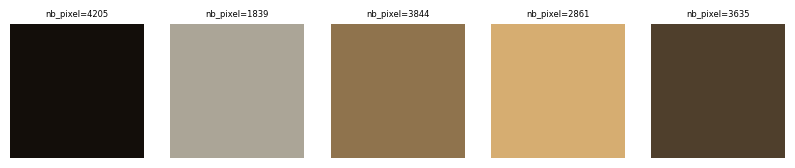

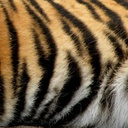

In [ ]:
#@title Target image {vertical-output: true}
#url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/marbled/marbled_0135.jpg'
#url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/dotted/dotted_0201.jpg'
#url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/braided/braided_0133.jpg'
#url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/honeycombed/honeycombed_0078.jpg'
url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/striped/striped_0097.jpg'
style_img = imread(url, max_size=128)
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
torch.cuda.set_device(device)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.current_device()
layers=[1, 6, 11, 18, 25]
with torch.no_grad():
  loss_f = create_vgg_loss(to_nchw(style_img), layers)
  loss_kmeans = create_kmeans_loss(to_nchw(style_img),5, device)
  b, ch, w, h = to_nchw(style_img).shape
imshow(style_img)

In [ ]:
def test_params(hidden_n=96, chn=12, filters={'lap':True, 'sobel_x':True, 'sobel_y':True, 'mean':False, 'id':True, 'canny':False}, k_means=False, height=h, width=w):
  #@title test parameters
  print(f"\nTesting params hidden_n={hidden_n}, chn={chn} and filters={[f for f in filters.keys() if filters[f]]}...")
  if filters.get('canny', False):
    print("WARNING: canny is way too computationally expensive. Consider using only sobel instead.")
  ca = CA(hidden_n=hidden_n, chn=chn, filters=filters, height=height, width=width)
  opt = torch.optim.Adam(ca.parameters(), 2e-3, capturable=True)
  lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 2000], 0.3)
  loss_log = []
  loss_lkm_distance = []
  loss_lkm_distribution = []
  with torch.no_grad():
    pool = ca.seed(256)

  interrupted = False

  #Poids des fonctions de coût
  A = 1.
  B = 1.
  C = 1e4
  D = 1e4

  for i in range(5001):
    with torch.no_grad():
      batch_idx = np.random.choice(len(pool), 4, replace=False)
      x = pool[batch_idx]
      if i%8 == 0:
        x[:1] = ca.seed(1)
    step_n = np.random.randint(32, 64)
    for k in range(step_n):
      x = ca(x)
    overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
    loss_VGG = loss_f(to_rgb(x))
    loss = A*loss_VGG + B*overflow_loss

    if k_means:
      loss_distance, loss_distribution, diff_per_cluster = loss_kmeans(to_rgb(x))
      loss_lkm_distance.append(loss_distance)
      loss_lkm_distribution.append(loss_distribution)
      loss = loss + C*loss_distance + D*loss_distribution

    with torch.no_grad():
      loss.backward()
      for p in ca.parameters():
        p.grad /= (p.grad.norm()+1e-8)   # normalize gradients
      opt.step()
      opt.zero_grad()
      lr_sched.step()
      pool[batch_idx] = x                # update pool
      if loss.item() == np.NaN or loss.item() == np.Inf:
        interrupted = True
        print(f'Interruption at step {i}, loss is {loss.item()}')
        break
      else:
        loss_log.append(loss.item())
        if i%10 == 0:
          if k_means:
            display(Markdown(f'''
              chn: {chn}
              hidden_n: {hidden_n}
              step_n: {len(loss_log)}
              loss_f: {"{:.4e}".format((A*loss_VGG).item())}
              loss_overflow: {"{:.4e}".format((B*overflow_loss).item())}
              loss_distance: {"{:.4e}".format((C*loss_distance).item())}
              loss_distribution: {"{:.4e}".format((D*loss_distribution).item())}
              lr: {lr_sched.get_last_lr()[0]}
              '''), display_id='stats')
          else:
            display(Markdown(f'''
              chn: {chn}
              hidden_n: {hidden_n}
              step_n: {len(loss_log)}
              loss_f: {"{:.4e}".format((A*loss_VGG).item())}
              loss_overflow: {"{:.4e}".format((B*overflow_loss).item())}
              lr: {lr_sched.get_last_lr()[0]}
              '''), display_id='stats')
        if i%50==0:
          pl.plot(loss_log, '.', alpha=0.1)
          pl.yscale('log')
          pl.ylim(np.min(loss_log), loss_log[0])
          pl.tight_layout()
          pl.title(f"Loss for hidden_n: {hidden_n} and chn: {chn}")
          imshow(grab_plot(), id='log')
          imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
          imshow(np.hstack(imgs), id='batch')
        if i%200==0 and k_means:
          print("Difference d'affiliation pour chaque cluster : " + str(diff_per_cluster))
  if k_means:
    print(f"loss_distance={loss_distance}")
    print(f"loss_distribution={loss_distribution}")
    print(f"loss_f={loss_VGG}")
    return ca, interrupted, loss_lkm_distance, loss_lkm_distribution
  else:
    return ca, interrupted, None, None


Testing params hidden_n=96, chn=12 and filters=['lap', 'sobel_x', 'sobel_y', 'mean', 'id']...



              chn: 12
              hidden_n: 96
              step_n: 611
              loss_f: 2.1764e+07
              loss_overflow: 0.0000e+00
              loss_distance: 3.1127e+07
              loss_distribution: 9.0938e+06
              lr: 0.002
              

  pl.ylim(np.min(loss_log), loss_log[0])



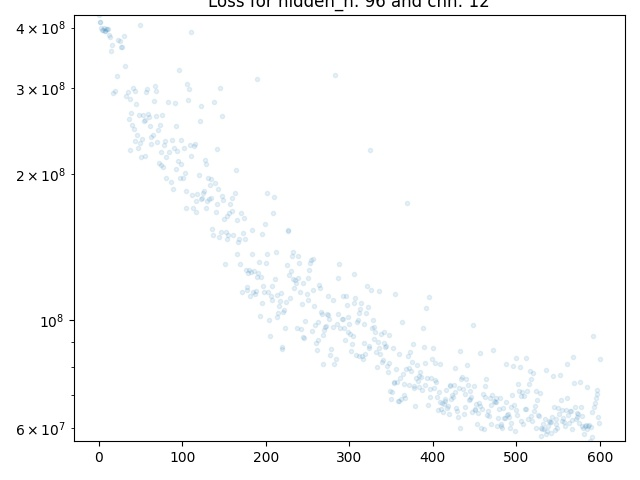

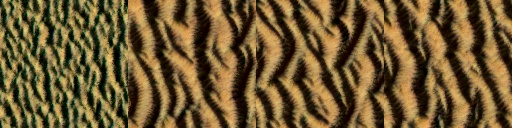

Difference d'affiliation pour chaque cluster : tensor([4175.1650, 3974.5669, 2966.4209,  509.7390, 2256.0820],
       grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([443.9832, 389.6531,  37.3159, 501.9497, 518.9639],
       grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([176.9170,  47.2588,  63.7529,  38.2852,  27.6201],
       grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([ 18.1523,  70.1635,  49.3882, 172.5437, 175.1665],
       grad_fn=<AbsBackward0>)



              chn: 12
              hidden_n: 96
              step_n: 5001
              loss_f: 1.8229e+07
              loss_overflow: 4.5013e-01
              loss_distance: 3.1637e+07
              loss_distribution: 2.0888e+06
              lr: 0.00017999999999999998
              

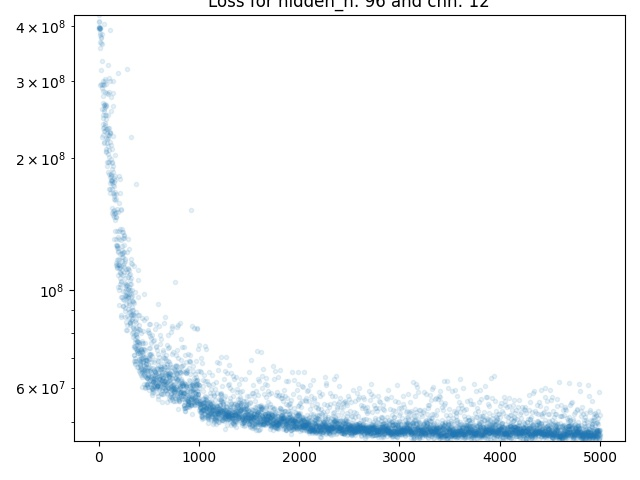

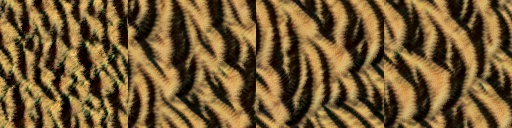

Difference d'affiliation pour chaque cluster : tensor([ 16.0791, 127.4919,  60.4727,  12.9790, 184.8643],
       grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([116.4829,  33.9346,  88.3157,  34.9004,  97.0020],
       grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([29.8462, 36.4749, 68.9194, 42.3989, 39.8010], grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([95.2573, 24.3796, 62.6919, 35.2632, 43.4490], grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([81.4478, 21.6669,  1.6912, 24.9727, 79.8330], grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([15.4658,  2.6218, 21.5911, 14.0139,  5.2664], grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([ 76.1489,  49.0784,  43.4531,  18.6069, 100.3813],
       grad_fn=<AbsBackward0>)
Difference d'affiliation pour chaque cluster : tensor([12.0254,  4.8804,  0.1099,  3.6182

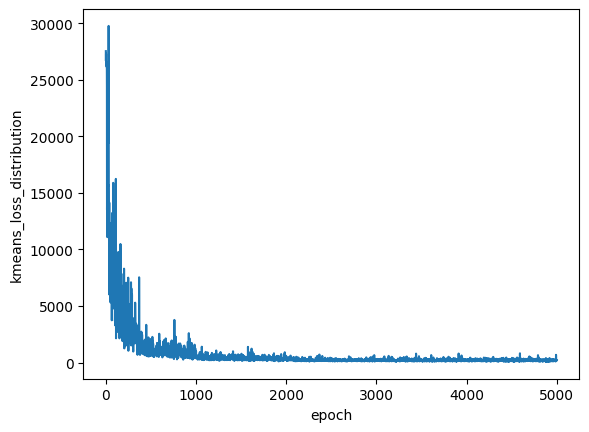

5001


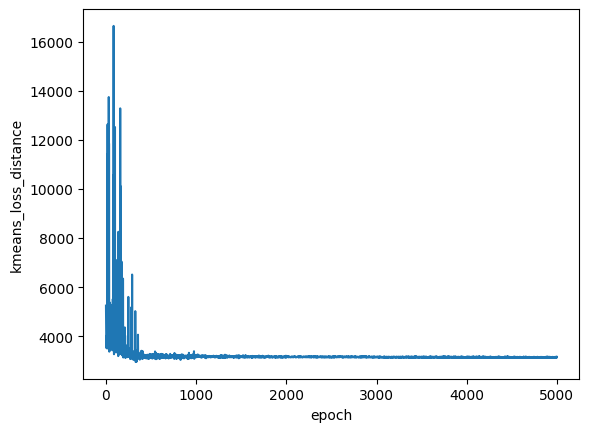

In [ ]:
#@title Entraînement du modèle
inter = True
while inter:
  try:
    ca_test, inter, loss_lkm_distance, loss_lkm_distribution = test_params(k_means=True, filters={'lap':True, 'sobel_x':True, 'sobel_y':True, 'mean':True, 'id':True, 'canny':False})
  except:
    inter = True
if loss_lkm_distribution is None:
  pass
else:
  values = [float(tensor) for tensor in loss_lkm_distribution]
  print(len(values))
  pl.plot(np.arange(len(values)), values)
  pl.xlabel("epoch")
  pl.ylabel("kmeans_loss_distribution")
  pl.show()

if loss_lkm_distance is None:
  pass
else:
  values = [float(tensor) for tensor in loss_lkm_distance]
  print(len(values))
  pl.plot(np.arange(len(values)), values)
  pl.xlabel("epoch")
  pl.ylabel("kmeans_loss_distance")
  pl.show()


  for k in tnrange(300, leave=False):



\image 1/15


  0%|          | 0/300 [00:00<?, ?it/s]

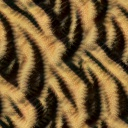

\image 2/15


  0%|          | 0/300 [00:00<?, ?it/s]

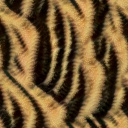

\image 3/15


  0%|          | 0/300 [00:00<?, ?it/s]

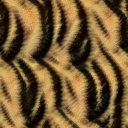

\image 4/15


  0%|          | 0/300 [00:00<?, ?it/s]

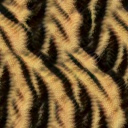

\image 5/15


  0%|          | 0/300 [00:00<?, ?it/s]

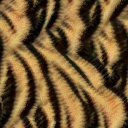

\image 6/15


  0%|          | 0/300 [00:00<?, ?it/s]

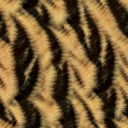

\image 7/15


  0%|          | 0/300 [00:00<?, ?it/s]

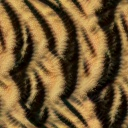

\image 8/15


  0%|          | 0/300 [00:00<?, ?it/s]

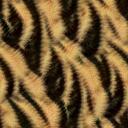

\image 9/15


  0%|          | 0/300 [00:00<?, ?it/s]

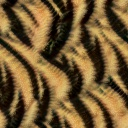

\image 10/15


  0%|          | 0/300 [00:00<?, ?it/s]

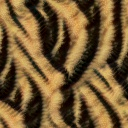

\image 11/15


  0%|          | 0/300 [00:00<?, ?it/s]

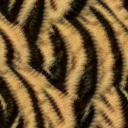

\image 12/15


  0%|          | 0/300 [00:00<?, ?it/s]

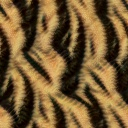

\image 13/15


  0%|          | 0/300 [00:00<?, ?it/s]

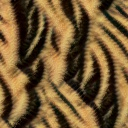

\image 14/15


  0%|          | 0/300 [00:00<?, ?it/s]

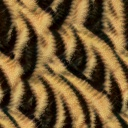

\image 15/15


  0%|          | 0/300 [00:00<?, ?it/s]

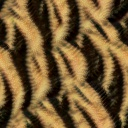

In [ ]:
#@title Génération de textures
for i in range(1, 16):
  print(f'\image {i}/15')
  with torch.no_grad():
    x = ca_test.seed(1)
    for k in tnrange(300, leave=False):
      step_n = min(2**(k//30), 8)
      for i in range(step_n):
        x[:] = ca_test(x)
    img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    imshow(img)
